# 0. Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [5]:
from sklearn.metrics import average_precision_score

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [7]:
from sklearn.metrics import f1_score,make_scorer
scored=make_scorer(f1_score)

# 1. Data I/O

In [8]:
data=pd.read_csv('df_impfeatures_withid.csv')
data.head()

,001_IPF_0,001_IPF_1,001_IPF_2,100_IPF_0,100_IPF_1,100_IPF_2,111_IPF_0,111_IPF_1,111_IPF_2,AspectRatios_0,...,Omega3s,QPEuc,Schmid,SurfaceAreaVolumeRatio,SurfaceFeatures,TJEuc,hotspot,fileID,file_source,mPrimeList
0,0.314819,0.427569,0.274501,0.214385,0.460550,0.372547,0.255733,0.607882,0.669000,0.821072,...,0.801818,0.766849,0.459804,3.897135,0.0,0.423802,False,1,1,0.588892
1,0.216026,0.467399,0.384040,0.542158,0.444626,0.125266,0.060509,0.545659,0.526708,0.896180,...,0.715912,0.727803,0.497166,3.968258,0.0,0.431682,False,1,1,0.129135
2,0.117264,0.510865,0.470377,0.248346,0.467535,0.376097,0.441562,0.429924,0.196210,0.808131,...,0.861303,0.766598,0.478242,3.163448,0.0,0.497570,False,1,1,0.010403
3,0.039997,0.558397,0.546043,0.526644,0.429348,0.060637,0.427246,0.507653,0.383033,0.592307,...,0.000004,0.823149,0.455669,3.661804,1.0,0.465144,False,1,1,0.161447
4,0.463466,0.426146,0.160350,0.409262,0.415742,0.181440,0.178657,0.484543,0.420328,0.908052,...,0.824643,0.781541,0.450828,3.237414,0.0,0.495204,False,1,1,0.045107


# 2. Data Exploration

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185177 entries, 0 to 185176
Data columns (total 29 columns):
001_IPF_0                     185177 non-null float64
001_IPF_1                     185177 non-null float64
001_IPF_2                     185177 non-null float64
100_IPF_0                     185177 non-null float64
100_IPF_1                     185177 non-null float64
100_IPF_2                     185177 non-null float64
111_IPF_0                     185177 non-null float64
111_IPF_1                     185177 non-null float64
111_IPF_2                     185177 non-null float64
AspectRatios_0                185177 non-null float64
AspectRatios_1                185177 non-null float64
AvgMisorientations            180059 non-null float64
EquivalentDiameters           185177 non-null float64
FeatureBoundaryElementFrac    185177 non-null float64
FeatureVolumes                185177 non-null float64
GBEuc                         185177 non-null float64
KernelAvg                

In [10]:
data.columns

Index(['001_IPF_0', '001_IPF_1', '001_IPF_2', '100_IPF_0', '100_IPF_1',
       '100_IPF_2', '111_IPF_0', '111_IPF_1', '111_IPF_2', 'AspectRatios_0',
       'AspectRatios_1', 'AvgMisorientations', 'EquivalentDiameters',
       'FeatureBoundaryElementFrac', 'FeatureVolumes', 'GBEuc', 'KernelAvg',
       'Neighborhoods', 'NumNeighbors', 'Omega3s', 'QPEuc', 'Schmid',
       'SurfaceAreaVolumeRatio', 'SurfaceFeatures', 'TJEuc', 'hotspot',
       'fileID', 'file_source', 'mPrimeList'],
      dtype='object')

In [11]:
data.fillna(0,inplace=True)
data.hotspot.replace(False, 0 , inplace=True)
data.hotspot.replace(True, 1 , inplace=True)

In [12]:
data['hotspot'].value_counts() # Skewed data

0.0    166643
1.0     18534
Name: hotspot, dtype: int64

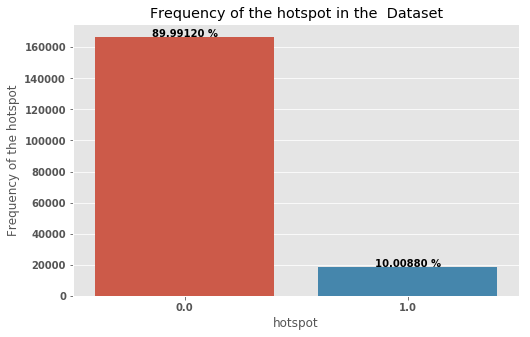

In [14]:
import matplotlib.style as style
style.use('ggplot')
plt.figure(figsize=(8,5))
ax=sns.countplot(x='hotspot', data=data);
total=float(len(data))
plt.title('Frequency of the hotspot in the  Dataset')
plt.ylabel('Frequency of the hotspot')
plt.xlabel('hotspot')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")

# 3. Data preprocessing

In [17]:
df_raw=data

In [18]:
t1=df_raw.loc[df_raw['file_source'] == 1]
t2=df_raw.loc[df_raw['file_source'] == 2]
t3=df_raw.loc[df_raw['file_source'] == 3]
t4=df_raw.loc[df_raw['file_source'] == 4]
t5=df_raw.loc[df_raw['file_source'] == 5]
t6=df_raw.loc[df_raw['file_source'] == 6]

In [19]:
dataframe=[t1,t2,t3,t4,t5,t6]

# 4. Utility Functions

In [20]:
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'16'}

In [21]:
def data_prep(df,t,m):
    
    df_temp=data
    list=dataframe[t].index[dataframe[t]['fileID']  == m].tolist()
    #df_temp.drop(list,inplace=True)
    X_train=df_temp.drop(list).drop(columns='hotspot')
    X_test=dataframe[t].loc[dataframe[t]['fileID'] == m].drop(columns='hotspot') 
    Y_train = df_temp.drop(list).hotspot
    Y_test= dataframe[t].loc[dataframe[t]['fileID'] == m].hotspot
    
    return(X_train,Y_train,X_test,Y_test)

In [22]:
import itertools

def plot_confusion_matrix(axd,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.sca(axd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1#print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=16)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
def model_fitting_and_post_processing(clf,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=[0,1],cross_val=False):
    #average precision for the precision recall curves
    # passing dataframes into the function
    clf.fit(X_train.values,Y_train.values.ravel())
    #print(clf.best_estimator_)
    if cross_val:
        clf=clf.best_estimator_
        print('\n')
        print(clf)
        print('\n')
    predictions=clf.predict(X_test.values)
    #decision function
    try:
        Y_score = clf.decision_function(X_test.values)
    except:
        Y_score = clf.predict_proba(X_test.values)[:,1]
    #Y_score=clf.decision_function(X_test.values)
    # printing the accuracy
    print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
    # predicting probabilities
    post_probab_predictions=clf.predict_proba(X_test.values)
    # assiging the probability
    post_probab_predictions=post_probab_predictions[:,1]
    # now subplotting
    fig, axes=plt.subplots(2,2,figsize=(14,10))
    # Class Distribution
    plt.sca(axes[0,0])
    data_train=X_train.copy()
    data_train['hotspot']=Y_train.values
    data_train['hotspot']=data_train['hotspot'].map({1.0:'hotspot',0.0:'coldspot'})
    ax=sns.countplot(x='hotspot', data=data_train);
    total=float(len(data_train))
    plt.title('Frequency of the target class in the Training-set',**title_font)
    plt.ylabel('Frequency of the target',**axis_font)
    plt.xlabel('Target Class',**axis_font)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
        #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
    # Confusion Matrix
    cnf_matrix = confusion_matrix(Y_test.values,predictions)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
    axes[0,1].grid('off')

    # ROC CURVE
    fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
    roc_auc = auc(fpr,tpr)
    plt.style.use('ggplot')
    title_gp='ROC for '+clf_name+' Classifier'
    axes[1,0].set_title(title_gp)
    axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    axes[1,0].legend(loc='lower right')
    axes[1,0].plot([0,1],[0,1],'r--')
    axes[1,0].set_ylabel('True Positive Rate',**axis_font)
    axes[1,0].set_xlabel('False Positive Rate',**axis_font)
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
    average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
    axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
    axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_xlabel('Recall',**axis_font)
    axes[1,1].set_ylabel('Precision',**axis_font)
    title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
    axes[1,1].set_title(title_gp)


    fig.tight_layout()
    print('\n')
    print('----------------------- Complete Classification Report -----------------------\n')
    print(classification_report(Y_test.values,predictions))
    print('\n')
    print('--------------------------- Post-processed Plots --------------------------\n')    
    return (predictions,post_probab_predictions)

In [24]:
def feature_engineering(data):
    X=data.drop(['fileID','file_source','hotspot'],axis=1)
    Y=data[['hotspot']]

    X_feat_train,X_feat_test,Y_feat_train,Y_feat_test = train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.hotspot)
    
    X_feat_train.reset_index(inplace=True)
    X_feat_train.drop('index',axis=1,inplace=True)
    Y_feat_train.reset_index(inplace=True)
    Y_feat_train.drop('index',axis=1,inplace=True)
    X_feat_test.reset_index(inplace=True)
    X_feat_test.drop('index',axis=1,inplace=True)
    Y_feat_test.reset_index(inplace=True)
    Y_feat_test.drop('index',axis=1,inplace=True)

    return(X_feat_train,Y_feat_train,X_feat_test,Y_feat_test)

In [25]:
def sample_prep(data):
    X_rtrain=data_resampled.drop(['hotspot'],axis=1)
    Y_rtrain=data_resampled[['hotspot']]
    xcols=X_rtrain.columns.tolist()
    X_rtrain=StandardScaler().fit_transform(X_rtrain)
    X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)
    
    return (X_rtrain,Y_rtrain)

# 5. Model Building

## 5.1 Logisitic regression (benchmark)

The accruacy of Logistic Reg on the Test set:  0.7201405152224825


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.93      0.74      0.83      4611
         1.0       0.18      0.51      0.27       513

   micro avg       0.72      0.72      0.72      5124
   macro avg       0.56      0.63      0.55      5124
weighted avg       0.86      0.72      0.77      5124



--------------------------- Post-processed Plots --------------------------



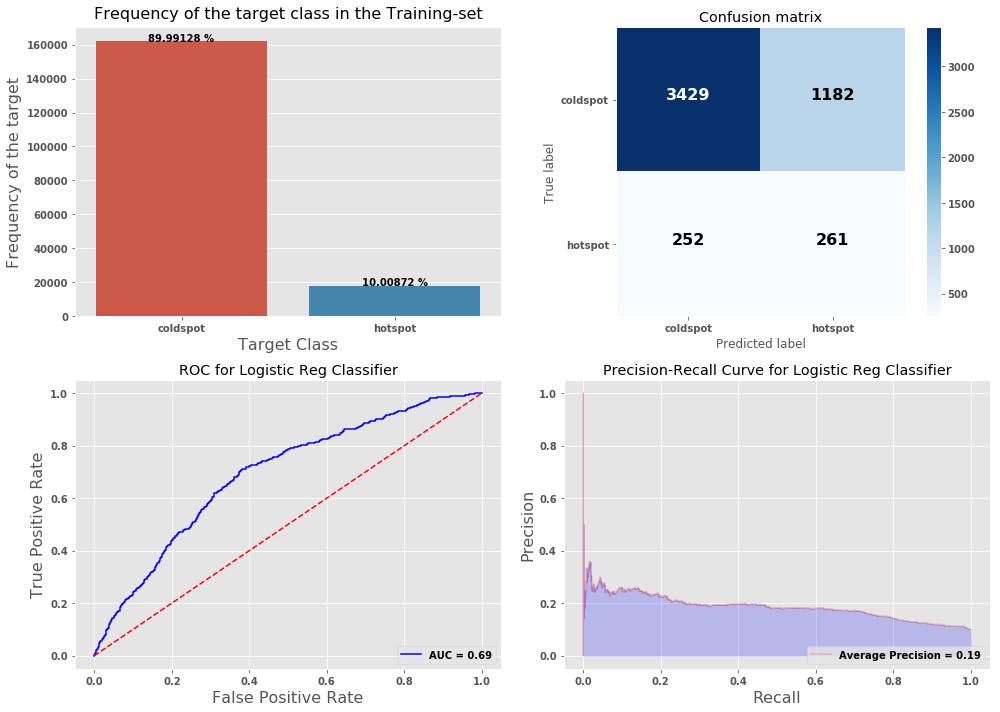

In [28]:
clf_log=LogisticRegression(class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,0,1)
pred_log1,pred_probab1=model_fitting_and_post_processing(clf_log,X_train,Y_train,X_test,Y_test,clf_name='Logistic Reg',class_names=['coldspot','hotspot'])

## 5.2 Logisitic regression with ADASYN (benchmark)

In [29]:
X_train,Y_train,X_test,Y_test=data_prep(data,0,1)

os_ada=ADASYN(random_state=0)
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['hotspot']=Y_oversampled
X_rtrain,Y_rtrain=sample_prep(data_resampled)

The accruacy of Logistic Reg + ADASYN on the Test set:  0.10636221701795472


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.92      0.01      0.02      4611
         1.0       0.10      0.99      0.18       513

   micro avg       0.11      0.11      0.11      5124
   macro avg       0.51      0.50      0.10      5124
weighted avg       0.84      0.11      0.03      5124



--------------------------- Post-processed Plots --------------------------



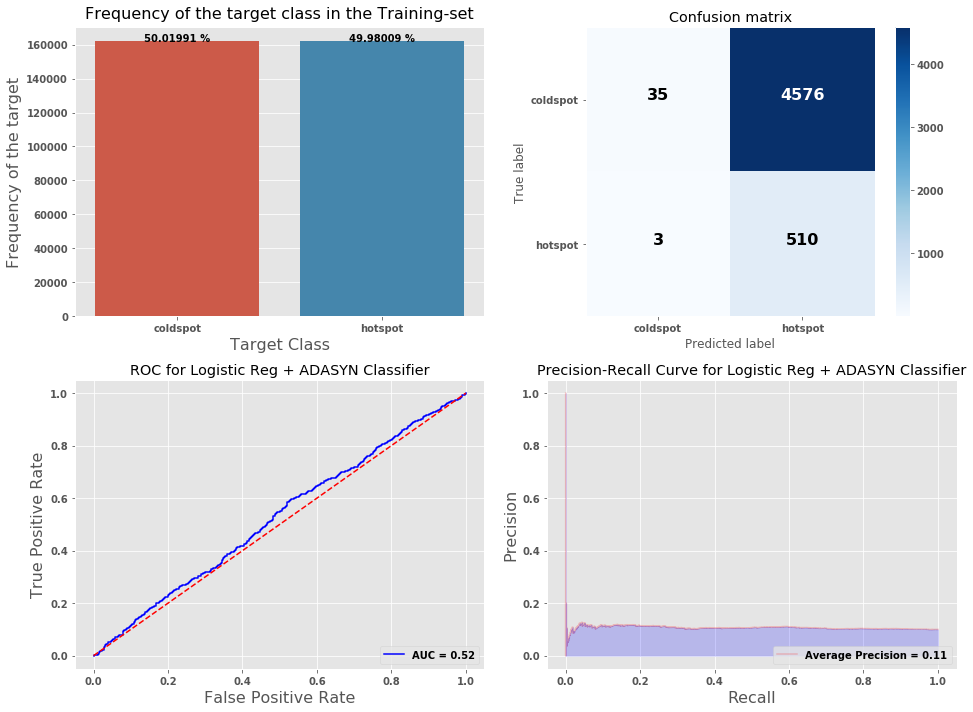

In [33]:
clf_log=LogisticRegression()
pred_log2,pred_probab2=model_fitting_and_post_processing(clf_log,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Logistic Reg + ADASYN',class_names=['coldspot','hotspot'])

## 5.3 Logisitic regression with Under Sampling(benchmark)

In [35]:
X_train,Y_train,X_test,Y_test=data_prep(data,0,1)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
xcols=X_train.columns.tolist()
X_undersampled,Y_undersampled=rus.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_undersampled,columns=xcols)
data_resampled['hotspot']=Y_undersampled
X_utrain,Y_utrain=sample_prep(data_resampled)

The accruacy of Logistic Reg + Rand Under on the Test set:  0.10011709601873536


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4611
         1.0       0.10      1.00      0.18       513

   micro avg       0.10      0.10      0.10      5124
   macro avg       0.05      0.50      0.09      5124
weighted avg       0.01      0.10      0.02      5124



--------------------------- Post-processed Plots --------------------------



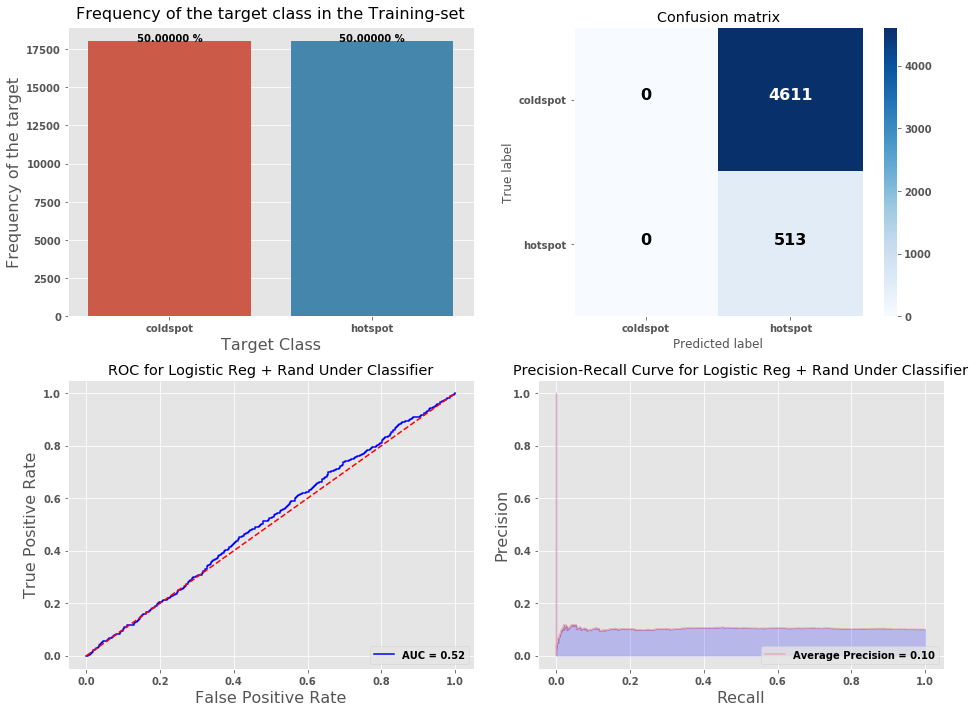

In [36]:
clf_log=LogisticRegression()
pred_log3,pred_probab3=model_fitting_and_post_processing(clf_log,X_utrain,Y_utrain,X_test,Y_test,clf_name='Logistic Reg + Rand Under',class_names=['coldspot','hotspot'])

In [ ]:
#X_utrain,Y_utrain=sample_prep(data_resampled)

## 5.4 Random Forests 


The accruacy of Random Forests on the Test set:  0.6978922716627635


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81      4611
         1.0       0.19      0.62      0.29       513

   micro avg       0.70      0.70      0.70      5124
   macro avg       0.57      0.66      0.55      5124
weighted avg       0.87      0.70      0.76      5124



--------------------------- Post-processed Plots --------------------------



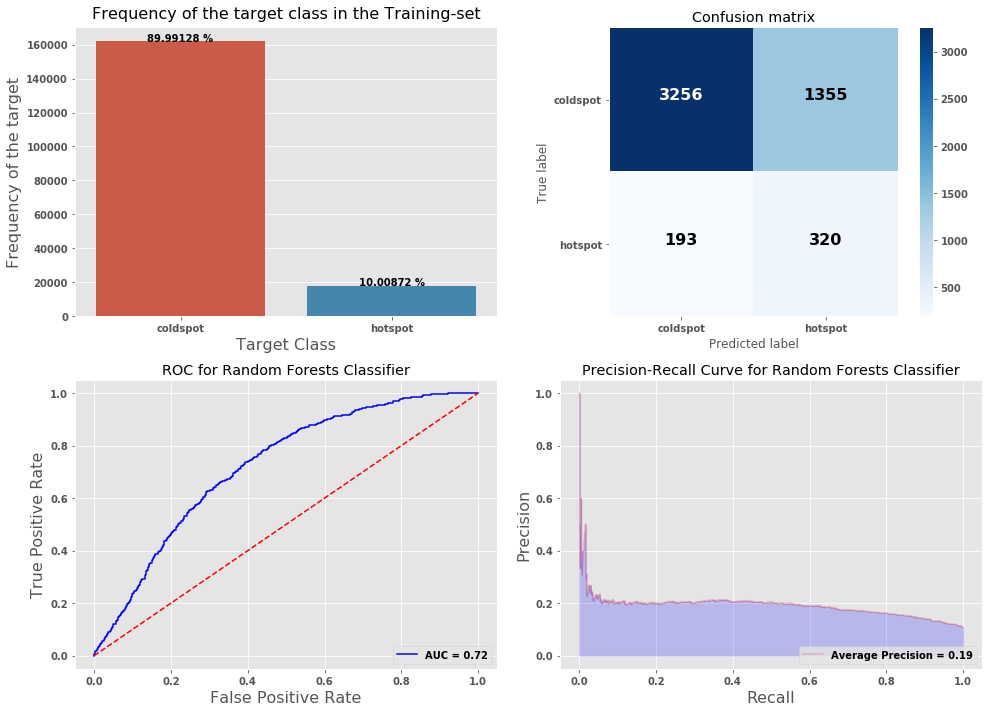

In [27]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0, class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,0,1)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.6890740023246803


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80      4645
         1.0       0.18      0.61      0.28       517

   micro avg       0.69      0.69      0.69      5162
   macro avg       0.56      0.65      0.54      5162
weighted avg       0.86      0.69      0.75      5162



--------------------------- Post-processed Plots --------------------------



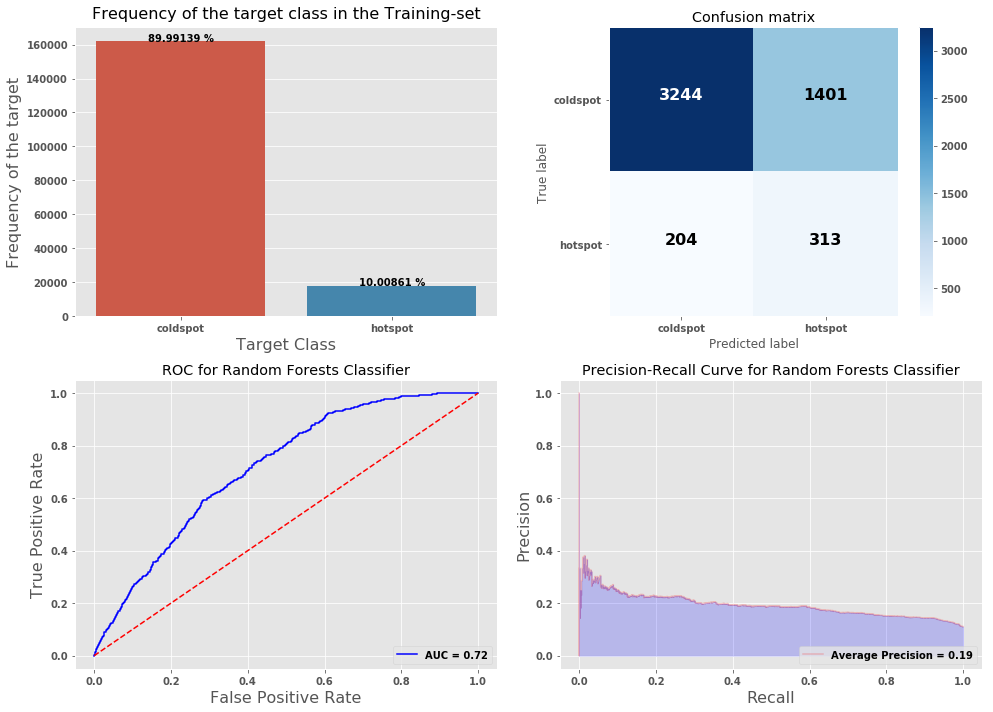

In [37]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0, class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,0,2)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.6822248152469856


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80      4627
         1.0       0.18      0.59      0.27       515

   micro avg       0.68      0.68      0.68      5142
   macro avg       0.56      0.64      0.53      5142
weighted avg       0.86      0.68      0.74      5142



--------------------------- Post-processed Plots --------------------------



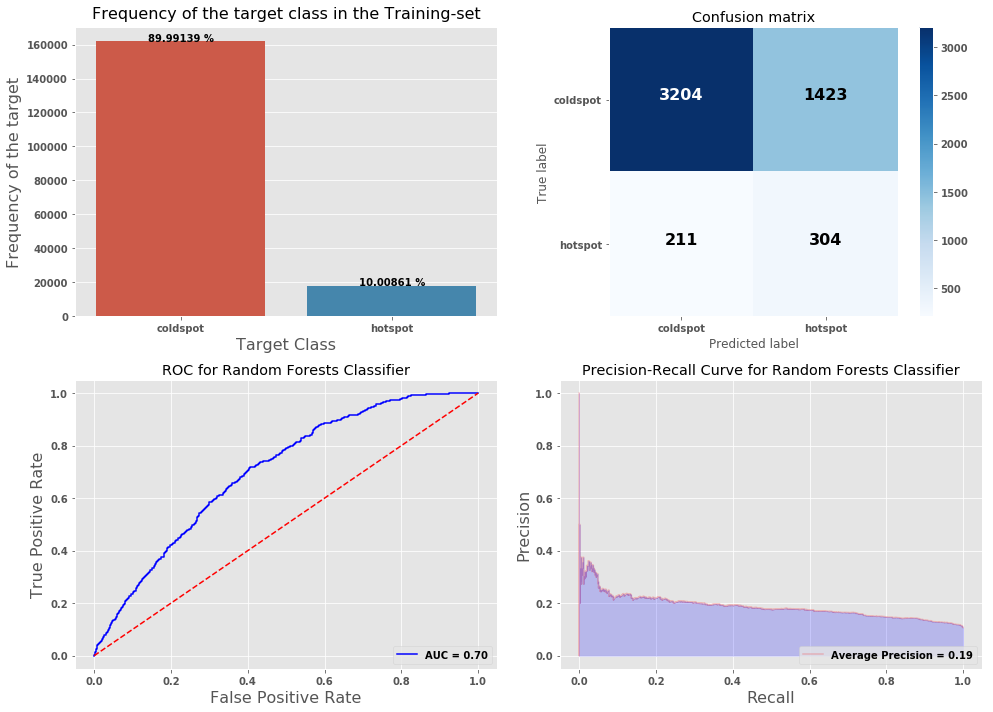

In [38]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0, class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,0,3)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.6894941634241245


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80      4626
         1.0       0.19      0.66      0.30       514

   micro avg       0.69      0.69      0.69      5140
   macro avg       0.57      0.68      0.55      5140
weighted avg       0.87      0.69      0.75      5140



--------------------------- Post-processed Plots --------------------------



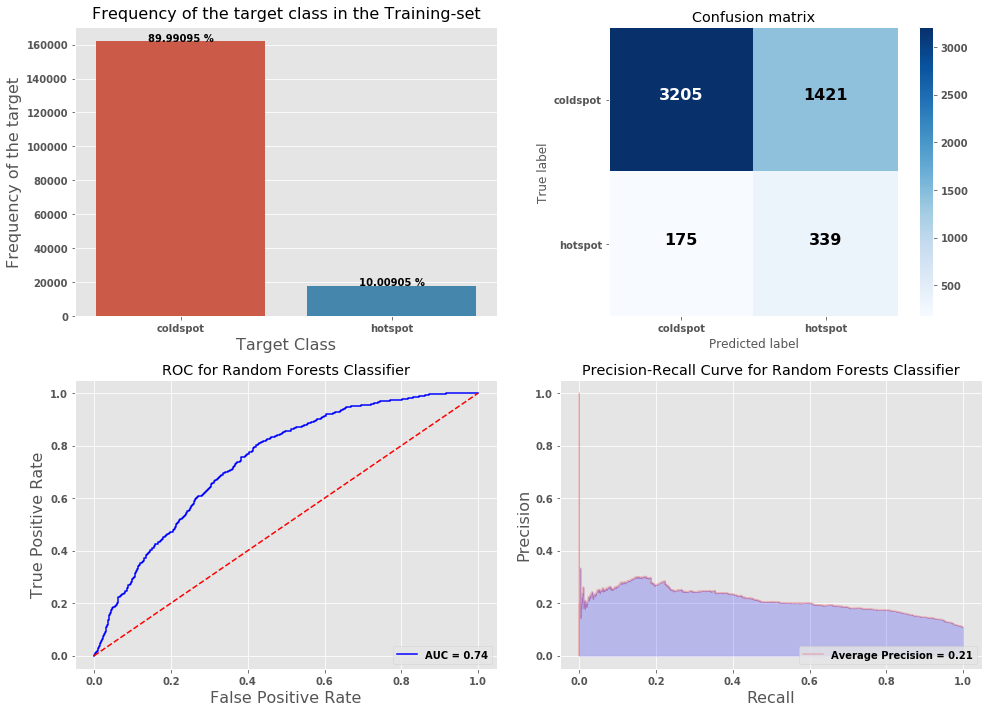

In [39]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0, class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,0,4)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.6929164254005018


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80      4662
         1.0       0.19      0.61      0.28       519

   micro avg       0.69      0.69      0.69      5181
   macro avg       0.56      0.65      0.54      5181
weighted avg       0.87      0.69      0.75      5181



--------------------------- Post-processed Plots --------------------------



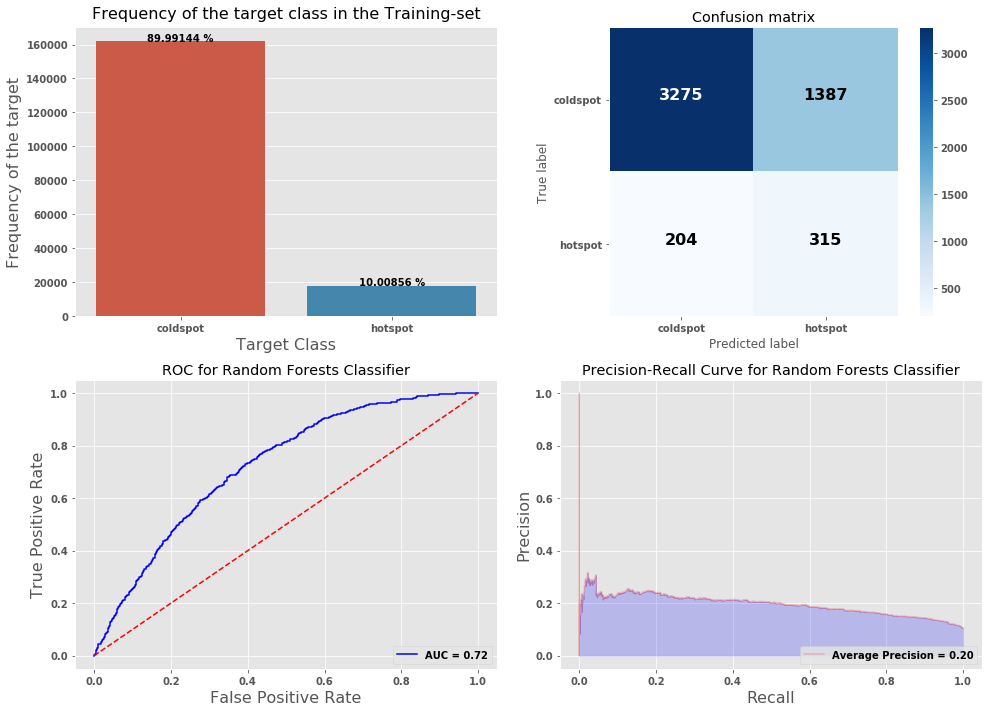

In [40]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0, class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,0,5)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.6922480620155039


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80      4644
         1.0       0.19      0.61      0.28       516

   micro avg       0.69      0.69      0.69      5160
   macro avg       0.56      0.66      0.54      5160
weighted avg       0.87      0.69      0.75      5160



--------------------------- Post-processed Plots --------------------------



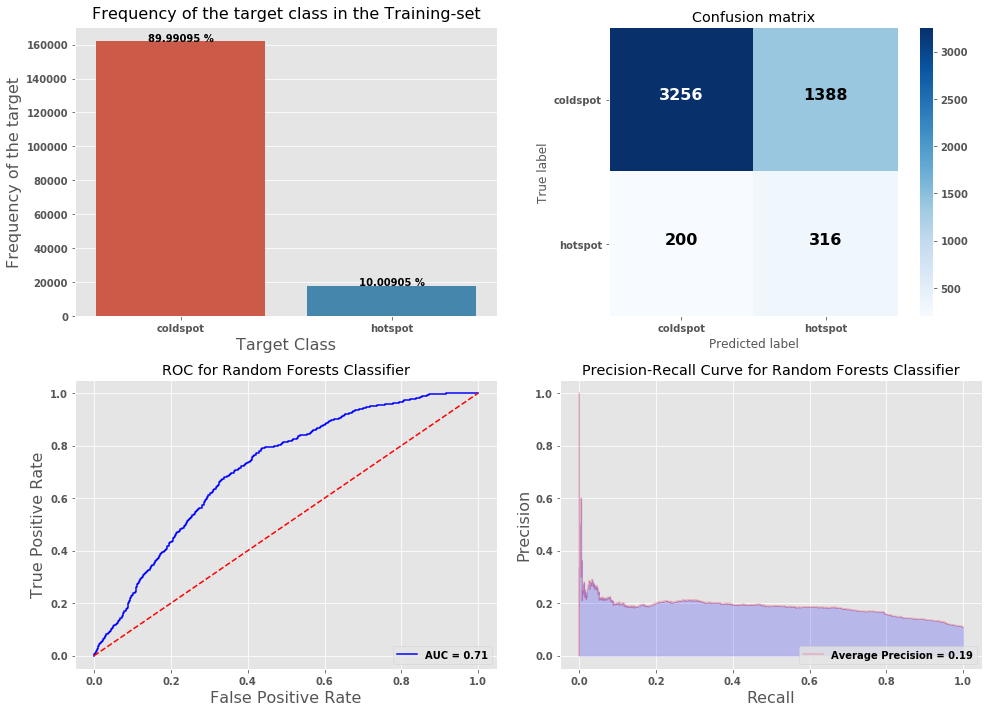

In [41]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0, class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,0,6)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

## 5.5 Random Forests + ADASYN

The accruacy of Random Forests + ADASYN on the Test set:  0.10011709601873536


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4611
         1.0       0.10      1.00      0.18       513

   micro avg       0.10      0.10      0.10      5124
   macro avg       0.05      0.50      0.09      5124
weighted avg       0.01      0.10      0.02      5124



--------------------------- Post-processed Plots --------------------------



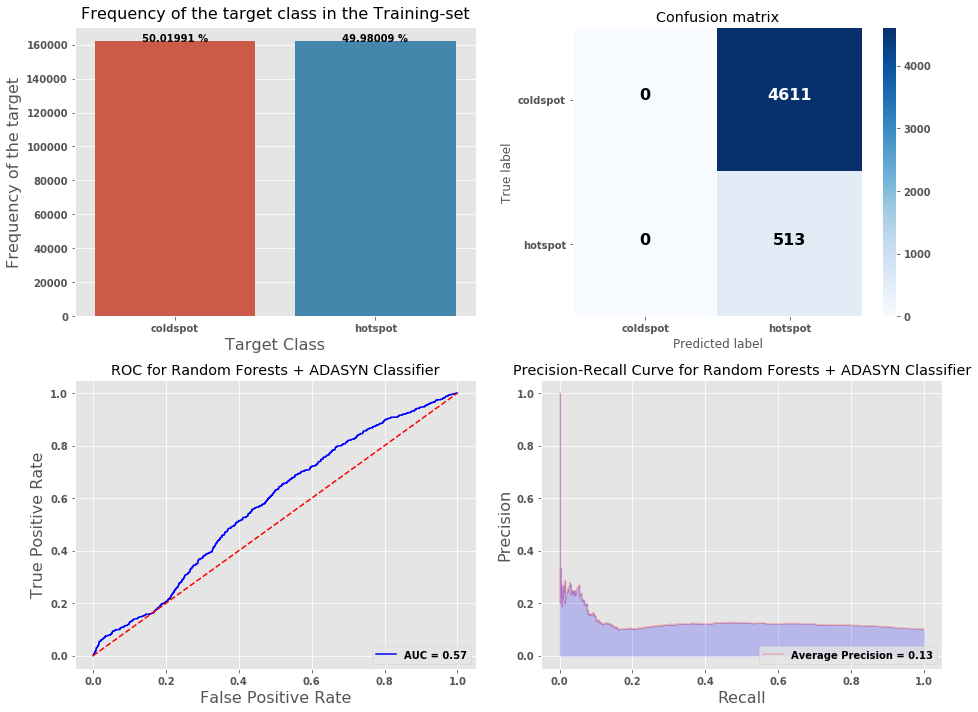

In [59]:
X_train,Y_train,X_test,Y_test=data_prep(data,0,1)

os_ada=ADASYN(random_state=0)
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['hotspot']=Y_oversampled
X_rtrain,Y_rtrain=sample_prep(data_resampled)

clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0)
preds_rf2,probab_rf2=model_fitting_and_post_processing(clf_rf,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Random Forests + ADASYN',class_names=['coldspot','hotspot'])

## 5.6 Random Forests + Random Under Sampling

The accruacy of Random Forests + Rand under sampling on the Test set:  0.8998829039812647


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      4611
         1.0       0.00      0.00      0.00       513

   micro avg       0.90      0.90      0.90      5124
   macro avg       0.45      0.50      0.47      5124
weighted avg       0.81      0.90      0.85      5124



--------------------------- Post-processed Plots --------------------------



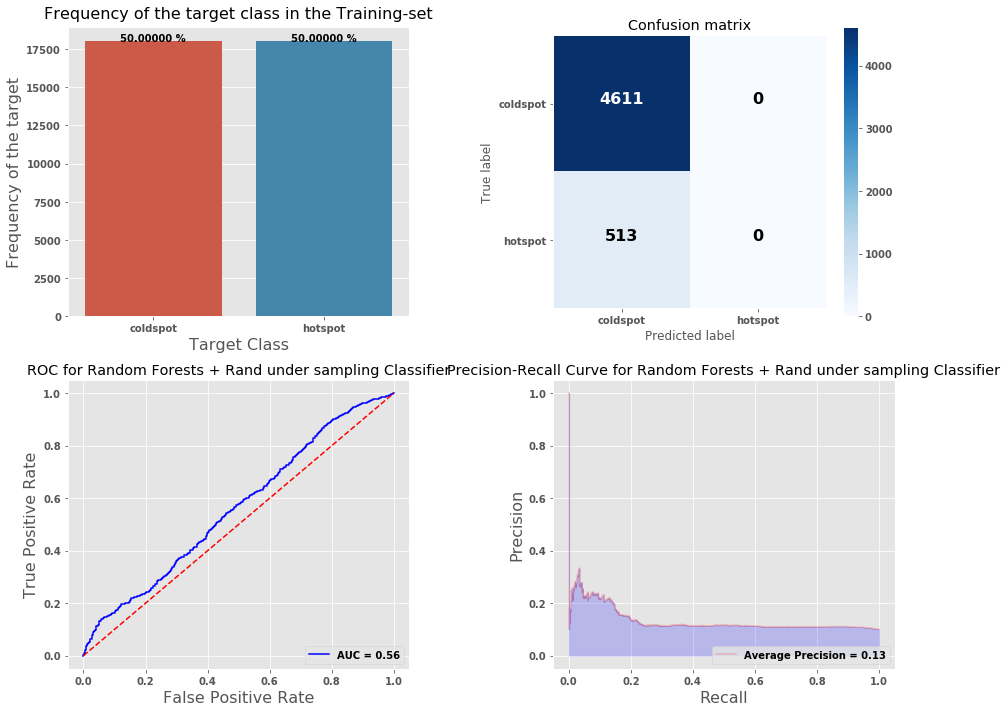

In [60]:
X_train,Y_train,X_test,Y_test=data_prep(data,0,1)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
xcols=X_train.columns.tolist()
X_undersampled,Y_undersampled=rus.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_undersampled,columns=xcols)
data_resampled['hotspot']=Y_undersampled
X_utrain,Y_utrain=sample_prep(data_resampled)



clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0)
preds_rf3,probab_rf3=model_fitting_and_post_processing(clf_rf,X_utrain,Y_utrain,X_test,Y_test,clf_name='Random Forests + Rand under sampling',class_names=['coldspot','hotspot'])

# Neural Networks

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

#import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.optimizers import SGD,Adam
import keras.backend as K
import keras.callbacks
from keras import regularizers

Using TensorFlow backend.


In [44]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [47]:
nb_classes=2
l1_num_neuron=300
l2_num_neuron=200
l3_num_neuron=200
output_neuron=nb_classes

In [48]:
layer_1 = Dense(l1_num_neuron, activation='relu',kernel_regularizer=regularizers.l2(0.01), input_dim=X_train.shape[1])
layer_2 = Dense(l2_num_neuron, activation='relu',kernel_regularizer=regularizers.l2(0.01))
layer_3 = Dense(l3_num_neuron, activation='relu',kernel_regularizer=regularizers.l2(0.01))
layer_out = Dense(output_neuron, activation='softmax',kernel_regularizer=regularizers.l2(0.01))

In [49]:
mlp=Sequential()
mlp.add(layer_1)
mlp.add(Dropout(0.3))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_2)
mlp.add(Dropout(0.3))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_3)
mlp.add(Dropout(0.3))
mlp.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.01))
mlp.add(layer_out)

In [50]:
sgd = SGD(lr=0.01, momentum=0.8, decay=0.1/200, nesterov=True)
#adm=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
mlp.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [51]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               8100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
__________

In [52]:
X_train_r,X_val,Y_train_r,Y_val=train_test_split(X_train,Y_train,random_state=0,test_size=0.1,stratify=Y_train.hotspot)

In [53]:
X_train_r=StandardScaler().fit_transform(X_train_r)
X_val=StandardScaler().fit_transform(X_val)
X_test=StandardScaler().fit_transform(X_test)

In [65]:
from keras.callbacks import EarlyStopping
train_res = mlp.fit(X_train_r,
                      Y_train_r.values.ravel(),
                      batch_size=256,
                      epochs=30,
                      verbose=True,
                      validation_data=(X_val,Y_val.values.ravel()),
                      callbacks=
                      [EarlyStopping(patience=4,mode='min',
                                     verbose=True)], class_weight={0:1,1:9} 
                      )

Train on 116660 samples, validate on 12963 samples
Epoch 1/30
116660/116660 [==============================] - 6s 49us/step - loss: 1.2752 - acc: 0.6957 - val_loss: 0.6438 - val_acc: 0.6025
Epoch 2/30
116660/116660 [==============================] - 6s 48us/step - loss: 1.1383 - acc: 0.5817 - val_loss: 0.6487 - val_acc: 0.5536
Epoch 3/30
116660/116660 [==============================] - 6s 48us/step - loss: 1.1320 - acc: 0.5881 - val_loss: 0.6274 - val_acc: 0.6040
Epoch 4/30
116660/116660 [==============================] - 6s 48us/step - loss: 1.1268 - acc: 0.5846 - val_loss: 0.6141 - val_acc: 0.6178
Epoch 5/30
116660/116660 [==============================] - 6s 49us/step - loss: 1.1246 - acc: 0.5975 - val_loss: 0.6368 - val_acc: 0.5741
Epoch 6/30
116660/116660 [==============================] - 6s 50us/step - loss: 1.1234 - acc: 0.5866 - val_loss: 0.6330 - val_acc: 0.5871
Epoch 7/30
116660/116660 [==============================] - 6s 48us/step - loss: 1.1200 - acc: 0.5911 - val_loss: 0

In [66]:
X_train,Y_train,X_test,Y_test=feature_engineering(data)

In [67]:
predictions=mlp.predict_classes(X_test,verbose=True)

55554/55554 [==============================] - 2s 37us/step


In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.values.ravel(),predictions)

0.7555891564963819

In [69]:
from sklearn.metrics import recall_score
recall_score(predictions,Y_test.values)

0.11503744958709429

In [70]:
from sklearn.metrics import precision_score
precision_score(predictions,Y_test.values)

0.21546762589928056

In [71]:
from sklearn.metrics import f1_score
f1_score(predictions,Y_test.values)

0.14999373982721922

In [72]:
#X_test.head()

In [73]:
post_probab_predictions=mlp.predict_proba(X_test,verbose=True)

55554/55554 [==============================] - 2s 37us/step


In [74]:
#post_probab_predictions

The accruacy of 3 layer Neural network on the Test set:  0.7555891564963819


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86     49994
         1.0       0.12      0.22      0.15      5560

   micro avg       0.76      0.76      0.76     55554
   macro avg       0.51      0.52      0.50     55554
weighted avg       0.82      0.76      0.79     55554



--------------------------- Post-processed Plots --------------------------



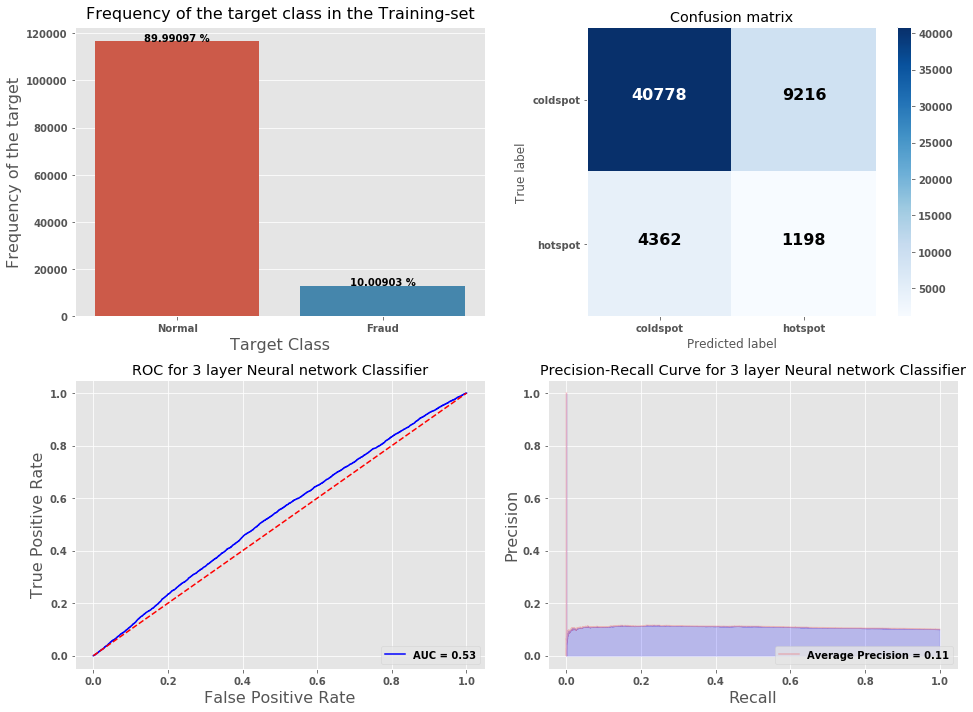

In [75]:
clf_name='3 layer Neural network'
class_names=['coldspot','hotspot']
print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
# predicting probabilities
#post_probab_predictions=clf.predict_proba(X_test.values)
# assiging the probability
post_probab_predictions=post_probab_predictions[:,1]
Y_score=post_probab_predictions
# now subplotting
fig, axes=plt.subplots(2,2,figsize=(14,10))
# Class Distribution
plt.sca(axes[0,0])
data_train=X_train.copy()
data_train['Class']=Y_train.values
data_train['Class']=data_train['Class'].map({1.0:'Fraud',0.0:'Normal'})
ax=sns.countplot(x='Class', data=data_train);
total=float(len(data_train))
plt.title('Frequency of the target class in the Training-set',**title_font)
plt.ylabel('Frequency of the target',**axis_font)
plt.xlabel('Target Class',**axis_font)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
    #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
# Confusion Matrix
cnf_matrix = confusion_matrix(Y_test.values,predictions)
np.set_printoptions(precision=2)
plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
axes[0,1].grid('off')
# ROC CURVE
fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
roc_auc = auc(fpr,tpr)
plt.style.use('ggplot')
title_gp='ROC for '+clf_name+' Classifier'
axes[1,0].set_title(title_gp)
axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
axes[1,0].legend(loc='lower right')
axes[1,0].plot([0,1],[0,1],'r--')
axes[1,0].set_ylabel('True Positive Rate',**axis_font)
axes[1,0].set_xlabel('False Positive Rate',**axis_font)
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
axes[1,1].legend(loc='lower right')
axes[1,1].set_xlabel('Recall',**axis_font)
axes[1,1].set_ylabel('Precision',**axis_font)
title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
axes[1,1].set_title(title_gp)

fig.tight_layout()
print('\n')
print('----------------------- Complete Classification Report -----------------------\n')
print(classification_report(Y_test.values,predictions))
print('\n')
print('--------------------------- Post-processed Plots --------------------------\n')    